In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import scipy
import torchvision
import umap
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression


def get_dataset(root, n):

    ds_train = torchvision.datasets.MNIST(root, train=True, download=False)
    ds_valid = torchvision.datasets.MNIST(root, train=False, download=False)

    indices = random.sample(range(len(ds_train)), n)

    imgs_train, labels_train = zip(*[(ds_train[idx][0], ds_train[idx][1]) for idx in indices])
    imgs_valid, labels_valid = zip(*[(item[0], item[1]) for item in ds_valid])

    data_train = np.zeros((len(imgs_train),28*28), dtype=np.float32)
    for idx, img in enumerate(imgs_train):
        data_train[idx] = np.array(img).flatten()

    data_valid = np.zeros((len(imgs_valid),28*28), dtype=np.float32)
    for idx, img in enumerate(imgs_valid):
        data_valid[idx] = np.array(img).flatten()

    u = data_train.mean()
    s = data_train.std()
    data_train = normalize(data_train, u, s)
    data_valid = normalize(data_valid, u, s)

    mapper = PCA(n_components=0.95, whiten=False)
    data_train_pca = mapper.fit_transform(data_train)
    data_valid_pca = mapper.transform(data_valid)
    u = data_train_pca.mean()
    s = data_train_pca.std()
    data_train_pca = normalize(data_train_pca, u, s)
    data_valid_pca = normalize(data_valid_pca, u, s)

    return data_train, labels_train, data_valid, labels_valid, data_train_pca, data_valid_pca

def plot(data, labels, s=3, figsize=(7,6)):
    plt.figure(figsize=figsize)
    plt.scatter(*data.T, s=s, c=labels, cmap='tab10')
    plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))

def create_image(model, data, eps=0.1, grid_resolution=300):

    x0, x1 = data.T

    x0_min, x0_max = x0.min() - eps, x0.max() + eps
    x1_min, x1_max = x1.min() - eps, x1.max() + eps

    xx0, xx1 = np.meshgrid(
        np.linspace(x0_min, x0_max, grid_resolution),
        np.linspace(x1_min, x1_max, grid_resolution),
    )

    data_grid = np.c_[xx0.ravel(), xx1.ravel()]

    response = model(data_grid)
    response = response.reshape(xx0.shape)

    return response, xx0, xx1

def plot_regions(model, data, labels, grid_resolution=300, eps=0.1):

    #colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99',
    #      '#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a']

    response, xx0, xx1 = create_image(model, data, eps=eps, grid_resolution=grid_resolution)

    fig, ax = plt.subplots(figsize=(7,6))
    co = ax.pcolormesh(xx0, xx1, response, 
                    cmap='tab10', alpha=0.5)
    sc = ax.scatter(*data.T, s=3, c=labels, cmap='tab10')
    fig.colorbar(sc, ax=ax)

def normalize(data, mean=None, std=None):

    if mean is None: mean = data.mean()
    if std is None: std = data.std()
    
    return (data-mean)/std

def get_prob(estimator, data, idx):
    '''Equivalent to estimator.predict_proba(data[idx:idx+1])'''

    logits = (estimator.coef_@data[idx:idx+1].T).T + estimator.intercept_
    probs_calc = scipy.special.softmax(logits)
    return probs_calc

def cross_entropy(estimator, data, labels):
    logs = estimator.predict_log_proba(data)
    logs_c = -logs[range(len(logs)), labels]

    return logs_c.mean()

root = 'K:/datasets/classification'
n = 5000
random.seed(42)

data_train, labels_train, data_valid, labels_valid, data_train_pca, data_valid_pca = get_dataset(root, n)

## Testing the quality of 2D projections

### Visualizations of the projections

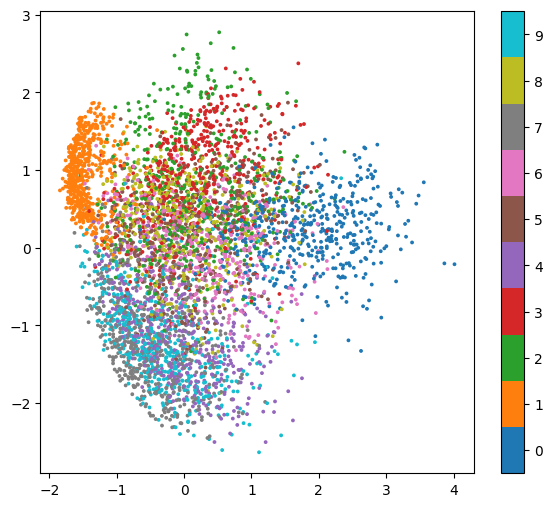

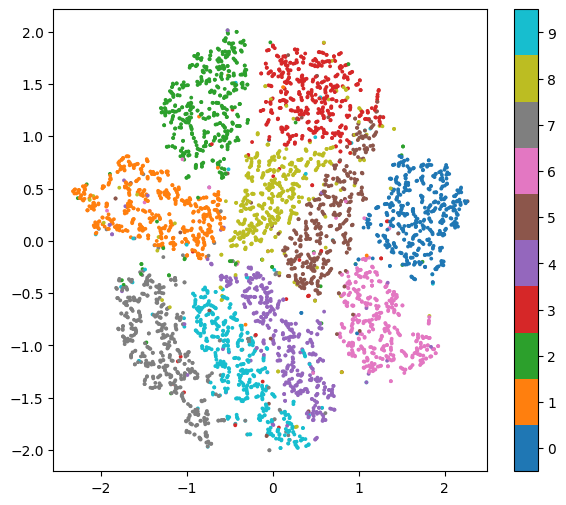

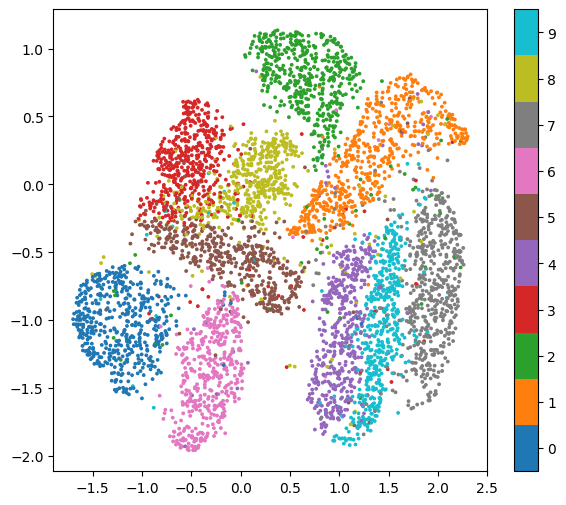

In [2]:
mapper = PCA(n_components=2, whiten=True)
proj_pca = mapper.fit_transform(data_train)
plot(proj_pca, labels_train)

#perplexity: effective number of nearest neighbors. [5,50]
#learning_rate: [10,1000]
mapper = TSNE(perplexity=7, learning_rate='auto')
proj_tsne = mapper.fit_transform(data_train)
proj_tsne = normalize(proj_tsne)
plot(proj_tsne, labels_train)

#n_neighbors: neighborhood to use
#min_dist: minimum distance
mapper = umap.UMAP(n_neighbors=10, min_dist=0.5)
proj_umap = mapper.fit_transform(data_train)
proj_umap = normalize(proj_umap)
plot(proj_umap, labels_train)

Accuracy: 89.74
Cross entropy: 0.7018684324146396


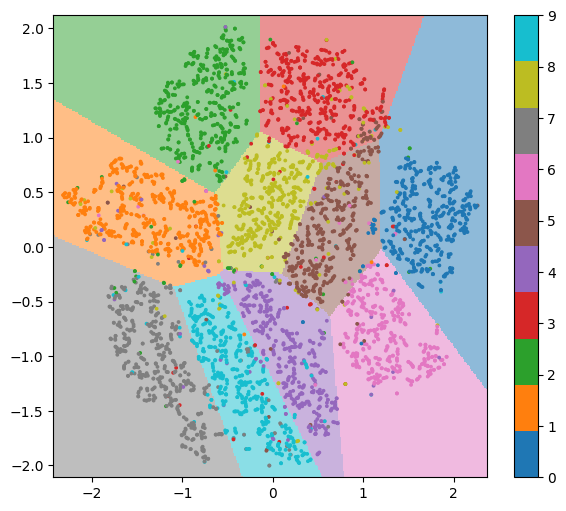

In [3]:
logreg = LogisticRegression(C=1000)
#knn = KNeighborsClassifier(n_neighbors=5, weights='uniform')
logreg.fit(proj_tsne, labels_train)
print('Accuracy:', 100*logreg.score(proj_tsne, labels_train))
print('Cross entropy:', cross_entropy(logreg, proj_tsne, labels_train))
plot_regions(logreg.predict, proj_tsne, labels_train)

### Plotting class scores

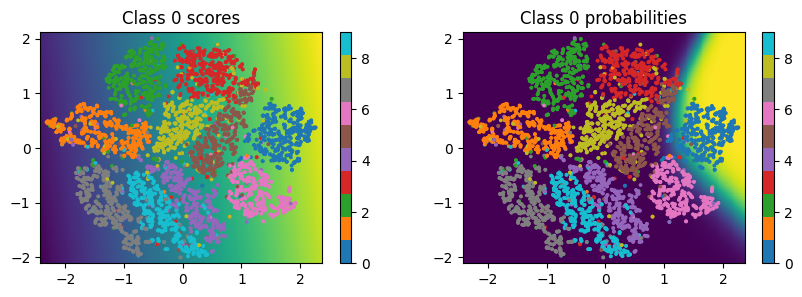

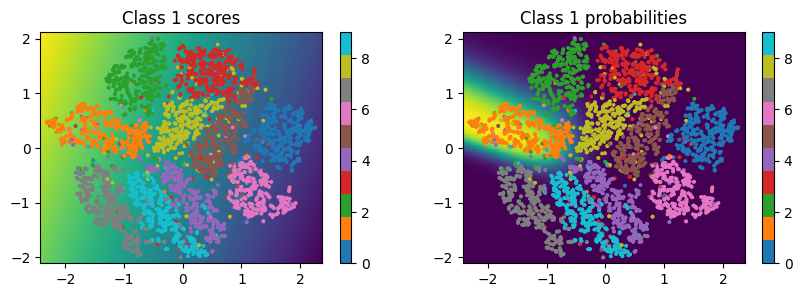

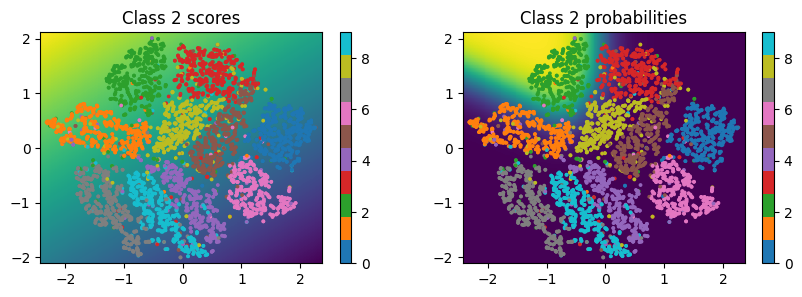

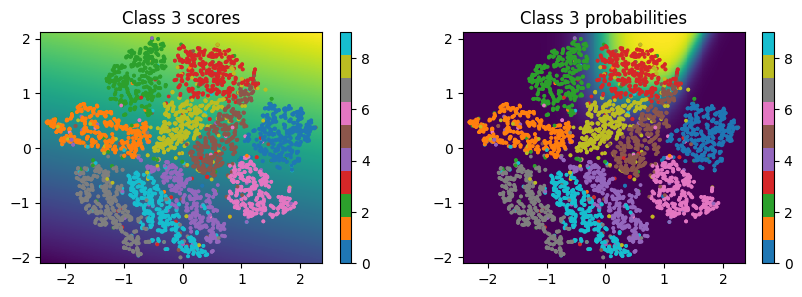

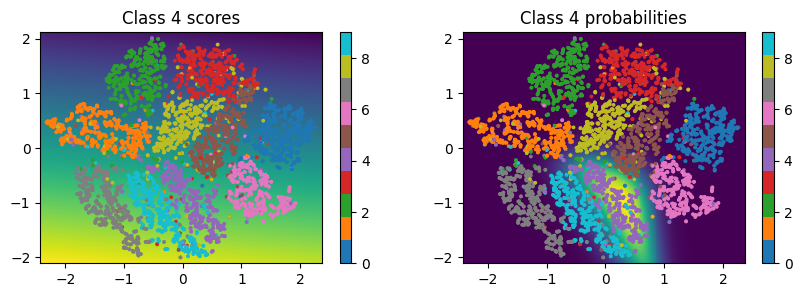

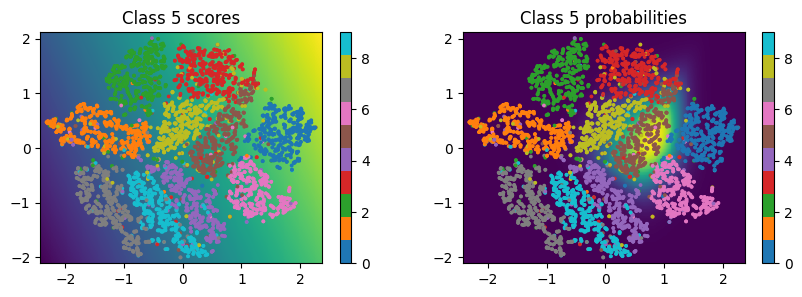

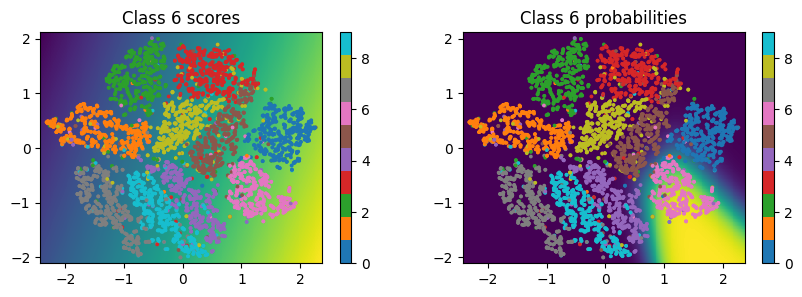

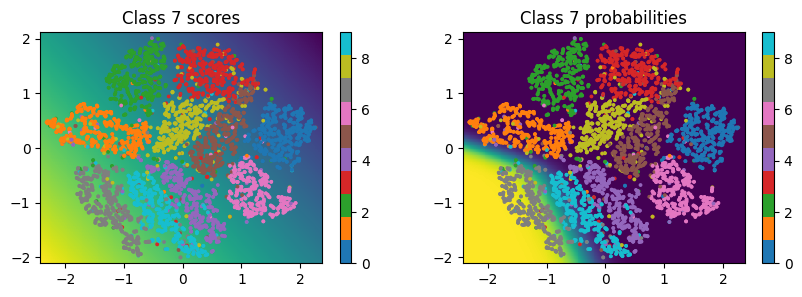

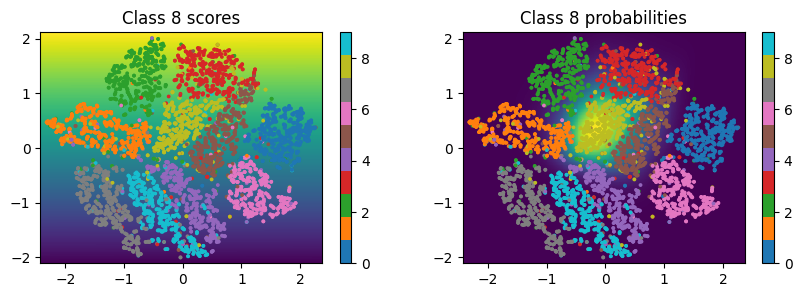

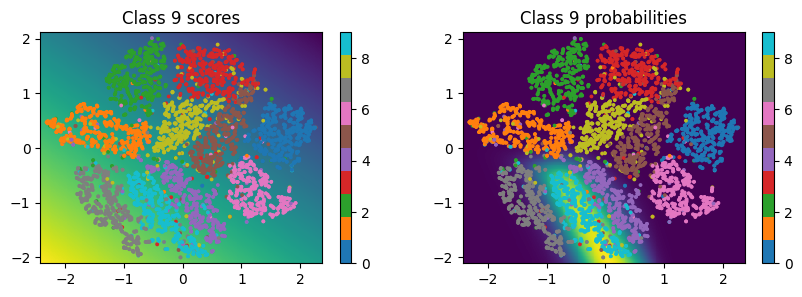

In [4]:
from functools import partial

class Model:
    '''Linear model'''

    def __init__(self, logreg):
    
        self.weights = logreg.coef_
        self.bias = logreg.intercept_

    def __call__(self, x):
        return x@self.weights.T + self.bias
    
def scores(data, model, c):
    logits = model(data)
    return logits[:,c]

def probs(data, model, c):
    logits = model(data)
    probs = scipy.special.softmax(logits, axis=1)
    return probs[:,c]

def plot_scores(model, data, labels_train):

    for c in range(10):

        scores_c = partial(scores, model=model, c=c)
        probs_c = partial(probs, model=model, c=c)

        response, xx0, xx1 = create_image(scores_c, data)

        fig, axes = plt.subplots(1, 2, figsize=(10,3))
        co = axes[0].pcolormesh(xx0, xx1, response)
        sc = axes[0].scatter(*data.T, s=3, c=labels_train, cmap='tab10')
        fig.colorbar(sc, ax=axes[0])
        axes[0].set_title(f'Class {c} scores')

        response, xx0, xx1 = create_image(probs_c, data)

        co = axes[1].pcolormesh(xx0, xx1, response)
        sc = axes[1].scatter(*data.T, s=3, c=labels_train, cmap='tab10')
        fig.colorbar(sc, ax=axes[1])
        axes[1].set_title(f'Class {c} probabilities')

model = Model(logreg)
plot_scores(model, proj_tsne, labels_train)

### Scores and probabilities between one class and the others

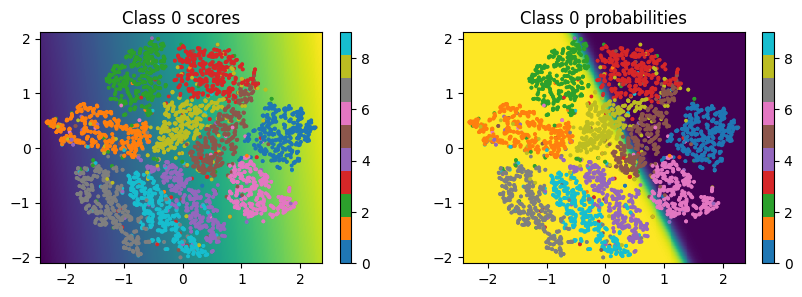

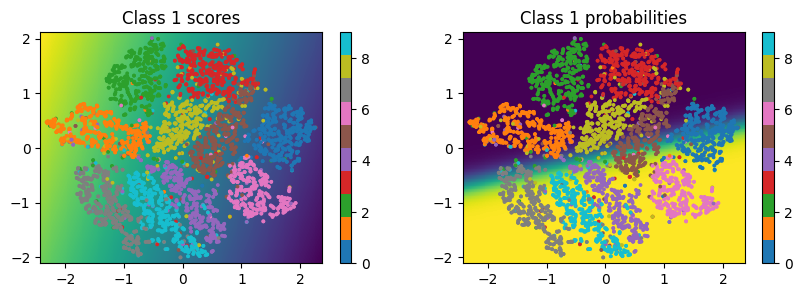

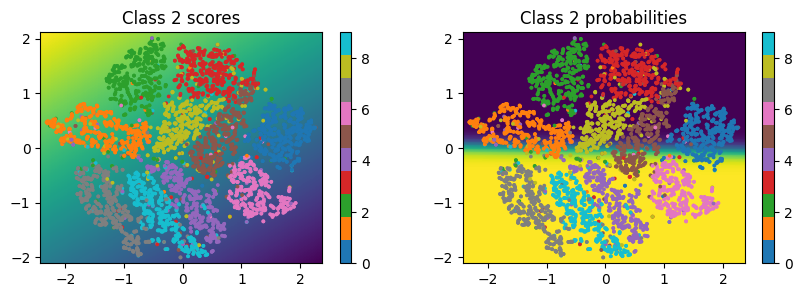

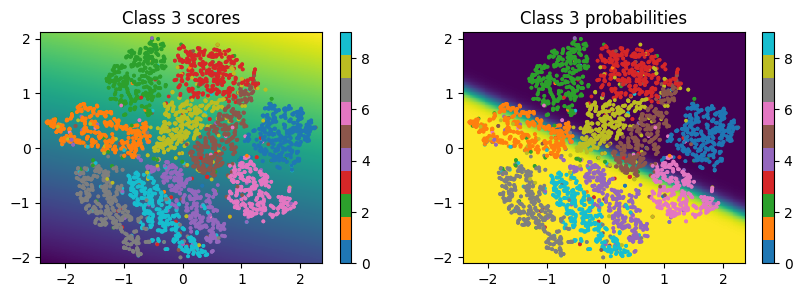

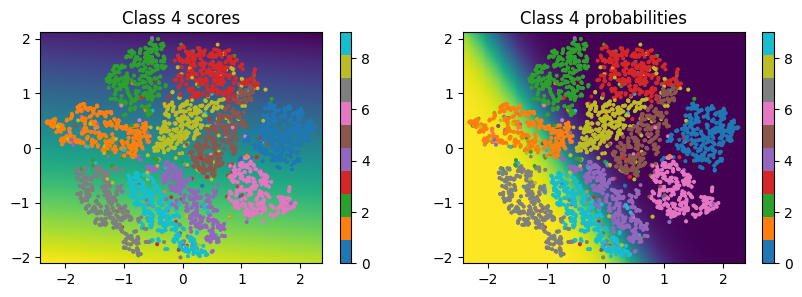

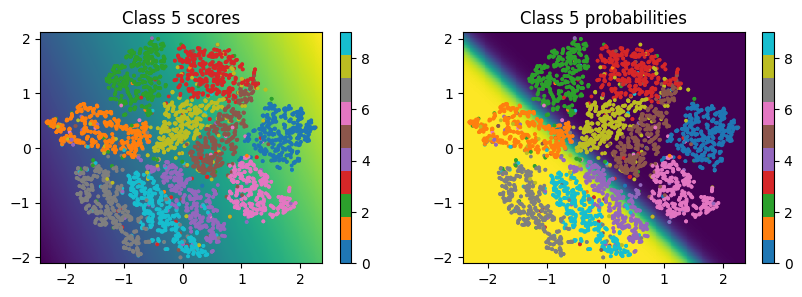

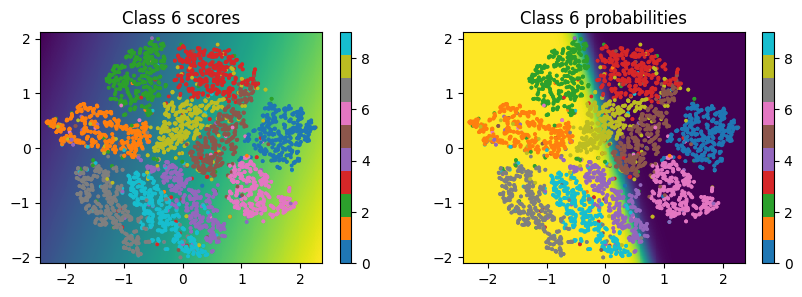

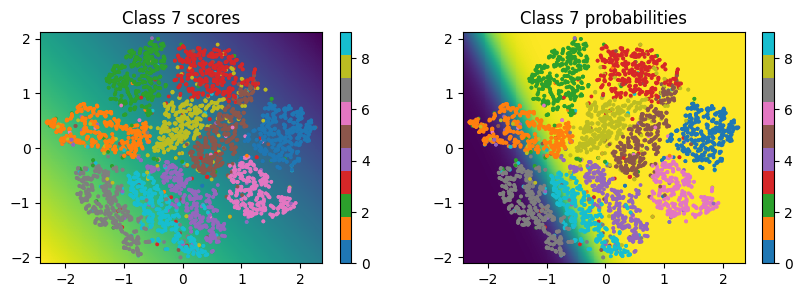

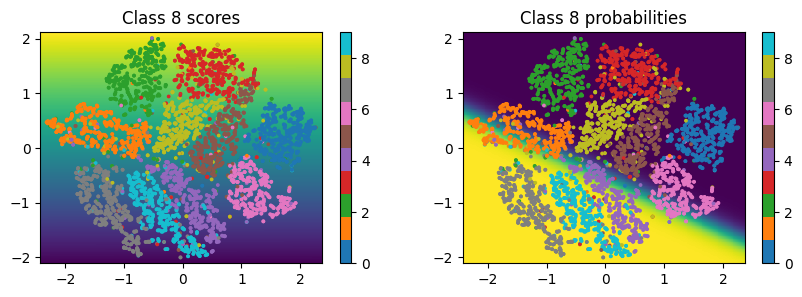

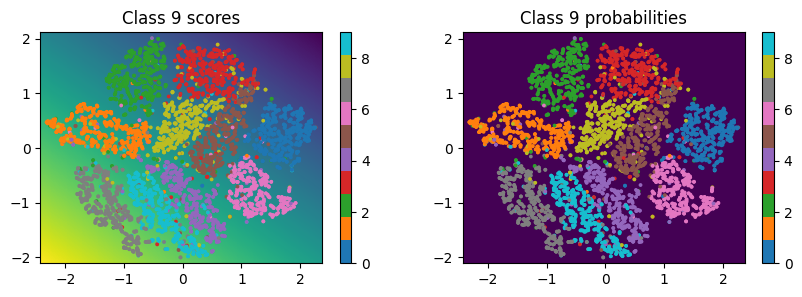

In [5]:
def probs_2_class(data, model, c1, c2):
    logits = model(data)
    logits = logits[:,[c1, c2]]
    probs = scipy.special.softmax(logits, axis=1)
    return probs[:,0]

def plot_scores_2_class(model, data, labels_train, ref_class):

    for c in range(10):

        scores_c = partial(scores, model=model, c=c)
        probs_c = partial(probs_2_class, model=model, c1=ref_class, c2=c)

        response, xx0, xx1 = create_image(scores_c, data)

        fig, axes = plt.subplots(1, 2, figsize=(10,3))
        co = axes[0].pcolormesh(xx0, xx1, response)
        sc = axes[0].scatter(*data.T, s=3, c=labels_train, cmap='tab10')
        fig.colorbar(sc, ax=axes[0])
        axes[0].set_title(f'Class {c} scores')

        response, xx0, xx1 = create_image(probs_c, data)

        co = axes[1].pcolormesh(xx0, xx1, response)
        sc = axes[1].scatter(*data.T, s=3, c=labels_train, cmap='tab10')
        fig.colorbar(sc, ax=axes[1])
        axes[1].set_title(f'Class {c} probabilities')

model = Model(logreg)
plot_scores_2_class(model, proj_tsne, labels_train, ref_class=9)

### Linear separability of the projections

In [6]:
logreg = LogisticRegression(C=1000)
logreg.fit(proj_tsne, labels_train)
print('Accuracy:', 100*logreg.score(proj_tsne, labels_train))
print('Cross entropy:', cross_entropy(logreg, proj_tsne, labels_train))

logreg = LogisticRegression(C=0.1, max_iter=1000)
logreg.fit(data_train, labels_train)
print('\nTrain loss:', cross_entropy(logreg, data_train, labels_train))
print('Valid loss:', cross_entropy(logreg, data_valid, labels_valid))
print('Train accuracy:', logreg.score(data_train, labels_train))
print('Valid accuracy:', logreg.score(data_valid, labels_valid))

# Using PCA data
logreg = LogisticRegression(C=0.1, max_iter=1000)
logreg.fit(data_train_pca, labels_train)
print('\nTrain loss:', cross_entropy(logreg, data_train_pca, labels_train))
print('Valid loss:', cross_entropy(logreg, data_valid_pca, labels_valid))
print('Train accuracy:', logreg.score(data_train_pca, labels_train))
print('Valid accuracy:', logreg.score(data_valid_pca, labels_valid))

Accuracy: 89.74
Cross entropy: 0.7018684324146396

Train loss: 0.09315671621300707
Valid loss: 0.36015808095447416
Train accuracy: 0.9844
Valid accuracy: 0.8985

Train loss: 0.20877258474500568
Valid loss: 0.3207210743526742
Train accuracy: 0.9482
Valid accuracy: 0.9073
